In [3]:
import numpy as np
import mne # docu: https://mne.tools/stable/overview/index.html
import pandas as pd
import matplotlib.pyplot as plt

from PCIst import pci_st # https://github.com/renzocom/PCIst

from matplotlib import rcParams
rcParams['figure.figsize'] = 12,6

import sys
sys.path.append('../')
from src import data

%matplotlib widget

In [4]:
folder = 'external/nieus_tms_eeg_ebrains/derivatives/epochs/'
subject = 'sub-01'

eeg_epoched_data = np.load(data.path(folder+f'{subject}/eeg/{subject}_task-tmseeg_run-01_epochs.npy'))
metadata = pd.read_csv(data.path(folder+f'{subject}/eeg/{subject}_task-tmseeg_run-01_channels.tsv'), sep = '\t')
montage = mne.channels.read_custom_montage(data.path(folder+f'{subject}/eeg/{subject}_task-tmseeg_electrodes.tsv'))
metadata.head()

,high_cutoff,low_cutoff,name,sampling_frequency,status,type,units
0,NaN,0.1,Fp1,725.0,good,EEG,uV
1,NaN,0.1,Fpz,725.0,good,EEG,uV
2,NaN,0.1,Fp2,725.0,good,EEG,uV
3,NaN,0.1,AF3,725.0,good,EEG,uV
4,NaN,0.1,AFz,725.0,good,EEG,uV


Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_5183/1334180634.py:3: RuntimeWarning: The unit for channel(s) AF3, AF4, AFz, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F1, F2, F3, F4, F5, F6, FC1, FC2, FC3, FC4, FC5, FC6, FCz, FT10, FT7, FT8, FT9, Fp1, Fp2, Fpz, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, PO1, PO2, POz, Pz, T7, T8, TP10, TP7, TP8, TP9 has changed from NA to V.
  epochs.set_channel_types({m:'eeg' for m in metadata.name})
/tmp/ipykernel_5183/1334180634.py:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


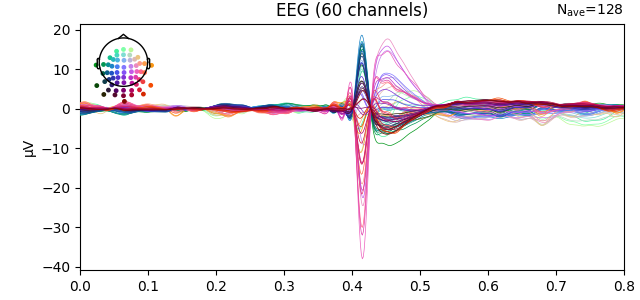

In [5]:
epochs_info = mne.create_info(list(metadata.name), metadata.iloc[0].sampling_frequency)
epochs = mne.EpochsArray(eeg_epoched_data,epochs_info)
epochs.set_channel_types({m:'eeg' for m in metadata.name})
epochs.set_montage(montage)
epochs.average("all").plot();

In [6]:
epochs_data = epochs.get_data() # (n_epochs, n_channels, n_times), dalo by se rovnou z načteného vstupu, ale to bych neměla hezký obrázek výše
epochs_data_averaged = np.mean(epochs_data,axis=0)

In [7]:
par = {'baseline_window':(0,0.35), 'response_window':(0.4,0.8), 'k':1.2, 'min_snr':1.1, 'max_var':98, 'embed':False,'n_steps':100} # 
pci_st_result = pci_st.calc_PCIst(epochs_data_averaged, epochs.times, full_return=True, **par)

"""
 'PCI': final PCI value,
 'dNST': list containing component wise PCIst value (∆NSTn),
 'n_dims': number of components,
 'D_base': base distance matrix,
 'D_resp': response distance matrix,
 'T_base': base transition matrix,
 'T_resp': response transition matrix,
 'thresholds': 2D array (n_steps, n_dims) - n_steps thresholds for each dimension,
 'NST_diff': 2D array (n_steps, n_dims) - n_steps values based on n_steps thresholds for each dimension,
 'NST_resp': 2D array (n_steps, n_dims) - n_steps values based on n_steps thresholds for each dimension,
 'NST_base': 2D array (n_steps, n_dims) - n_steps values based on n_steps thresholds for each dimension,
 'max_thresholds': threshold with maximum NST_diff for each dimension,
 'signal_evk': ,
 'times': ,
 'signal_svd': ,
 'eigenvalues': ,
 'var_exp': ,
 'snrs': signal to noise ratio for each component
"""

pci_st_result

{'PCI': 18.966371346535798,
 'dNST': [4.23872014640581,
  5.476651180888569,
  5.276164800605464,
  3.974835218635955],
 'n_dims': 4,
 'D_base': array([[[0.00000000e+00, 9.06661483e-08, 1.61779190e-07, ...,
          4.52651944e-06, 4.54678572e-06, 4.62004016e-06],
         [9.06661483e-08, 0.00000000e+00, 7.11130418e-08, ...,
          4.61718559e-06, 4.63745187e-06, 4.71070631e-06],
         [1.61779190e-07, 7.11130418e-08, 0.00000000e+00, ...,
          4.68829863e-06, 4.70856491e-06, 4.78181935e-06],
         ...,
         [4.52651944e-06, 4.61718559e-06, 4.68829863e-06, ...,
          0.00000000e+00, 2.02662790e-08, 9.35207213e-08],
         [4.54678572e-06, 4.63745187e-06, 4.70856491e-06, ...,
          2.02662790e-08, 0.00000000e+00, 7.32544423e-08],
         [4.62004016e-06, 4.71070631e-06, 4.78181935e-06, ...,
          9.35207213e-08, 7.32544423e-08, 0.00000000e+00]],
 
        [[0.00000000e+00, 2.10433792e-08, 2.94805228e-08, ...,
          3.64009331e-06, 3.59859213e-06, 3.

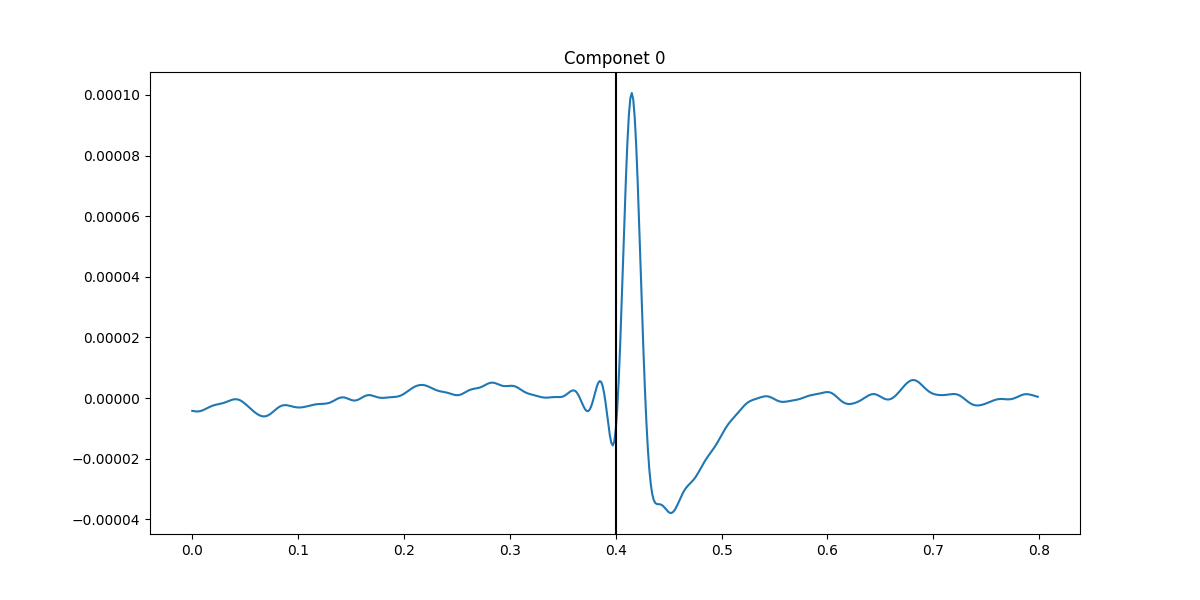

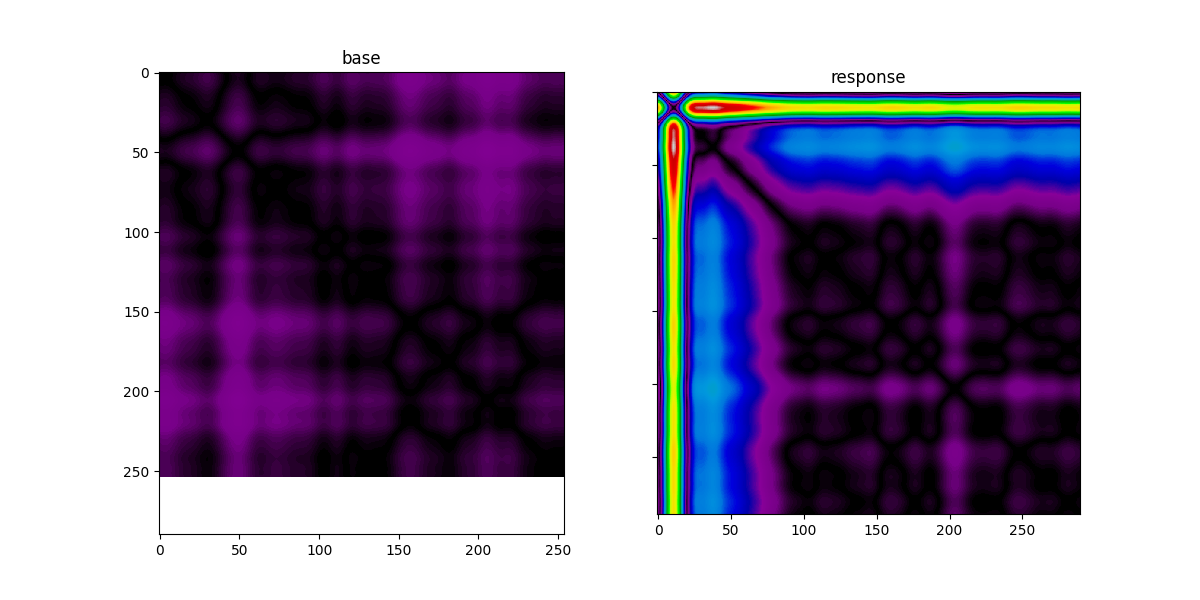

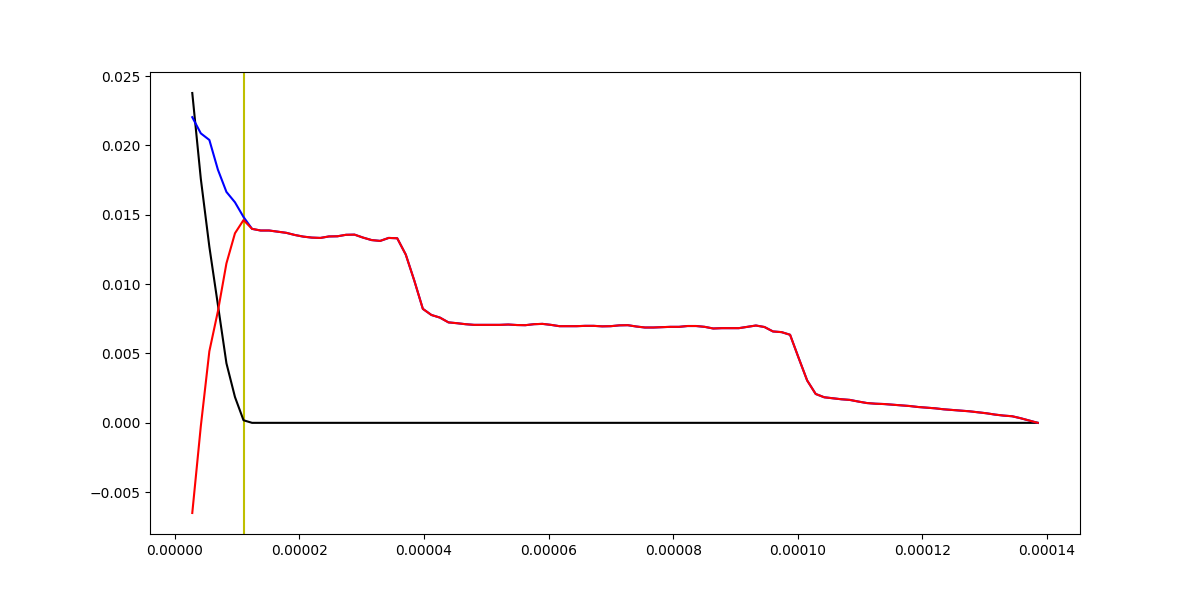

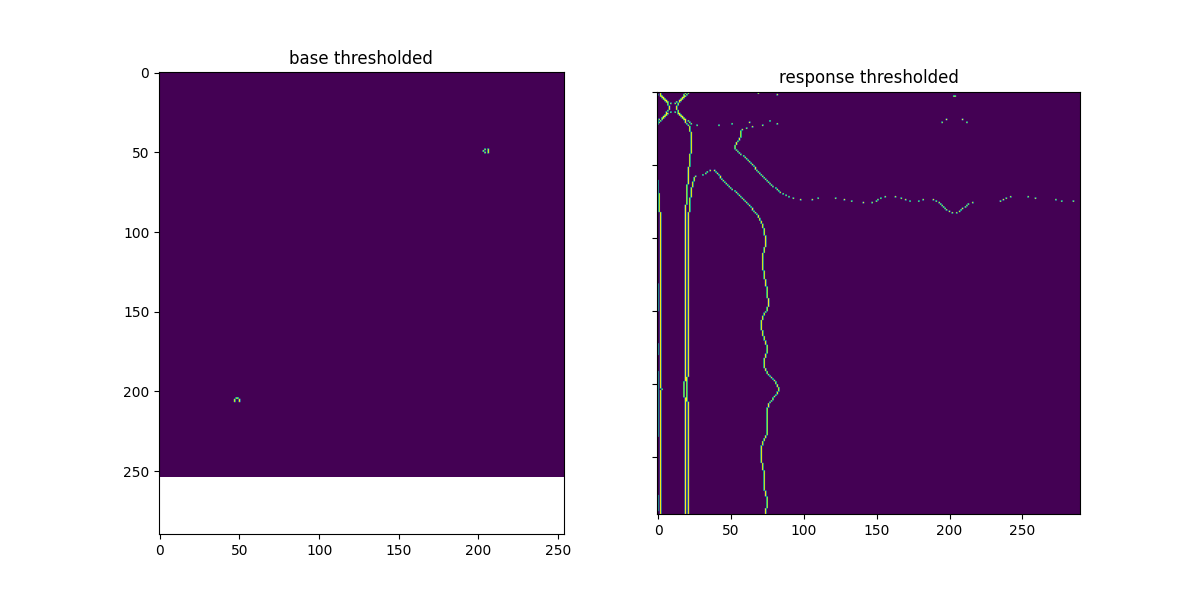

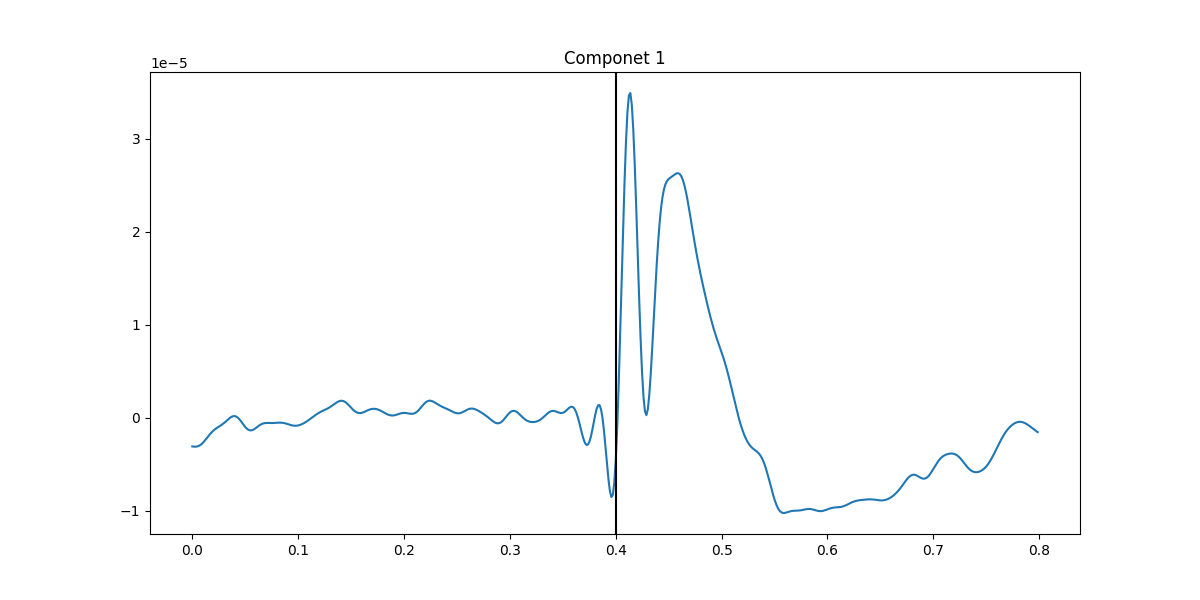

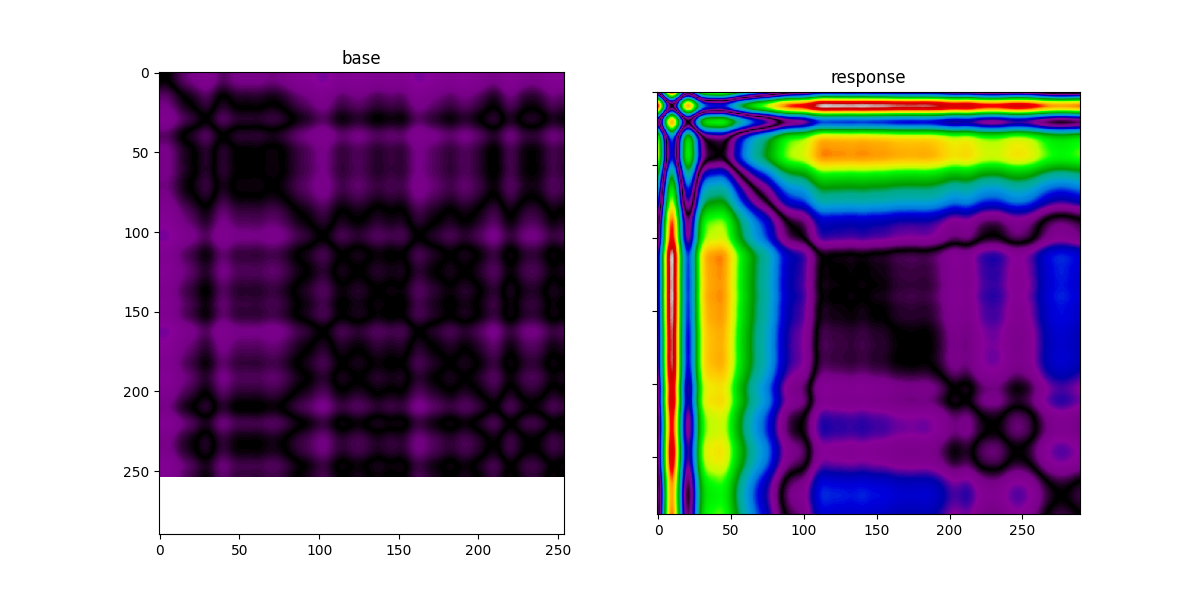

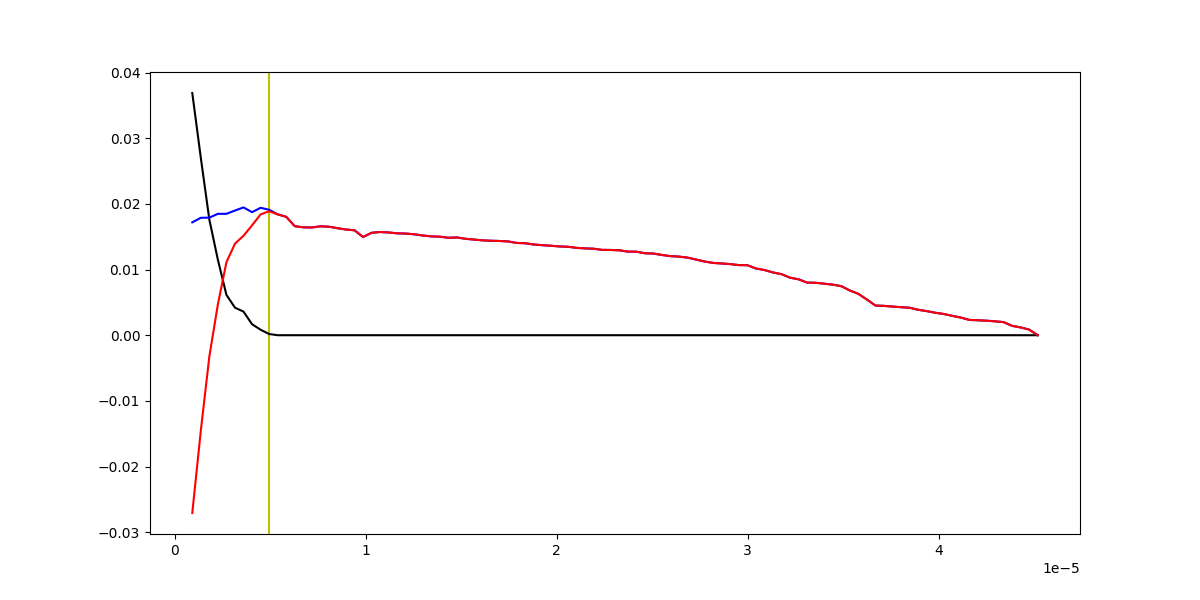

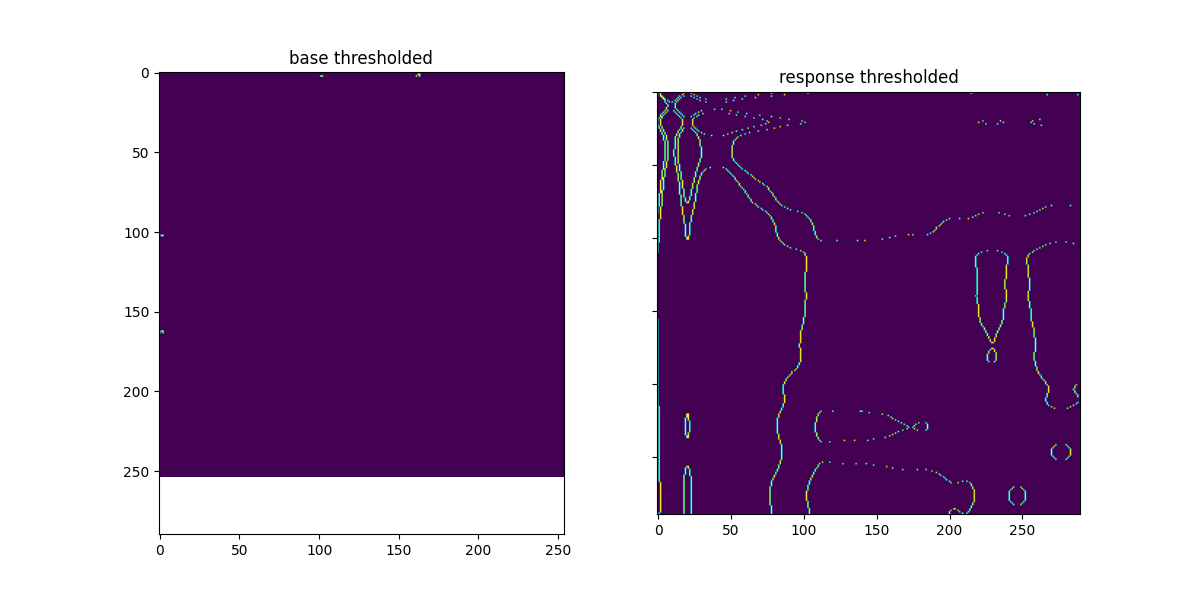

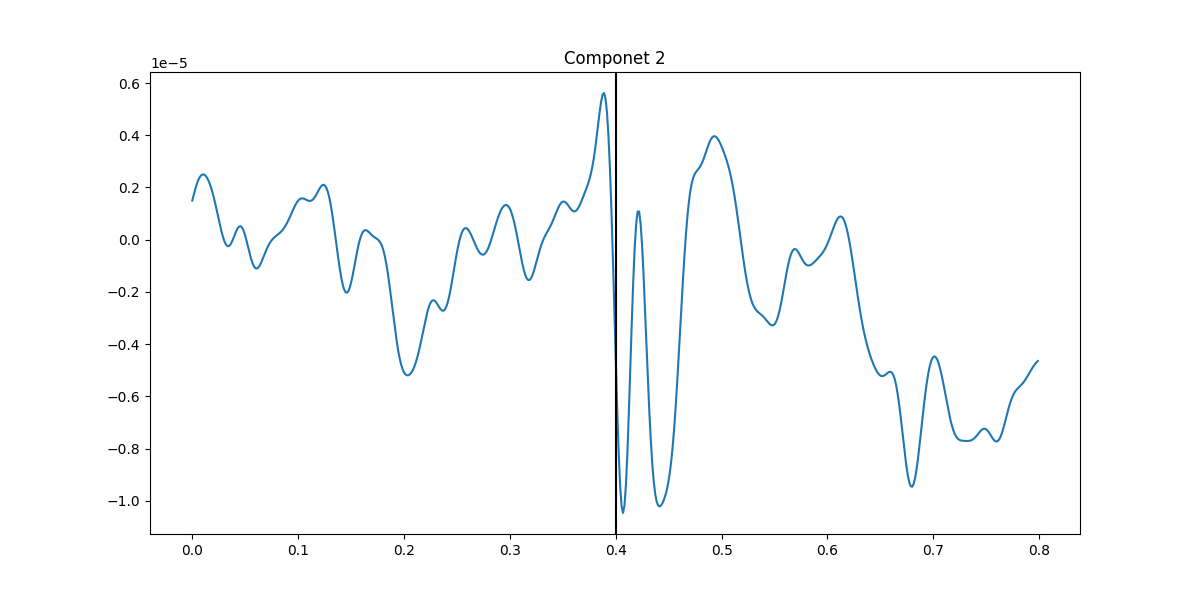

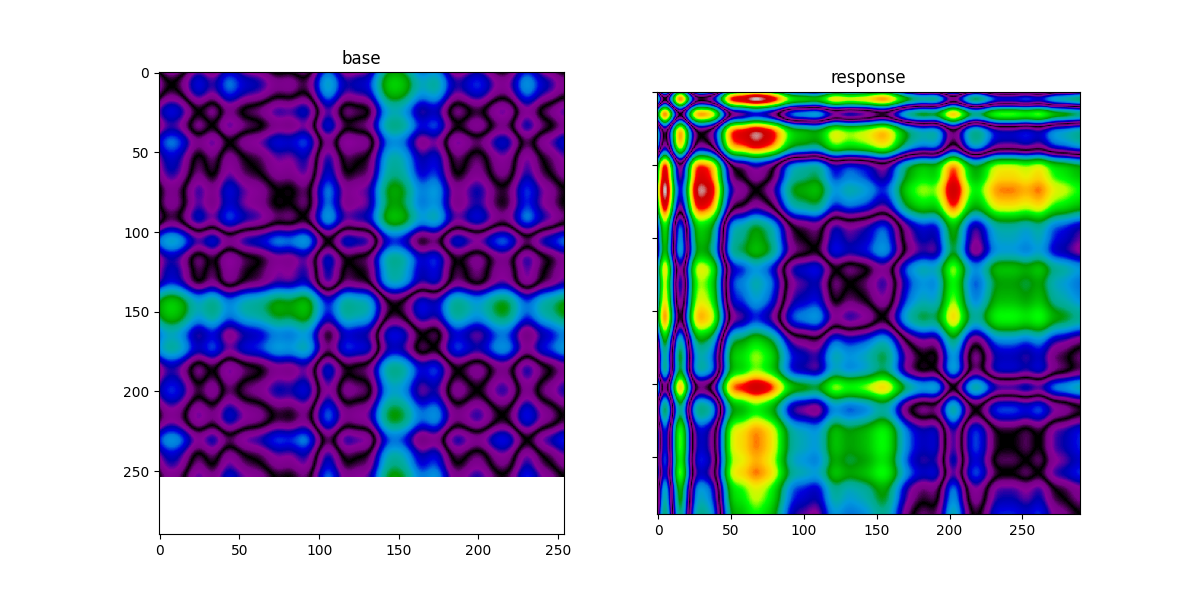

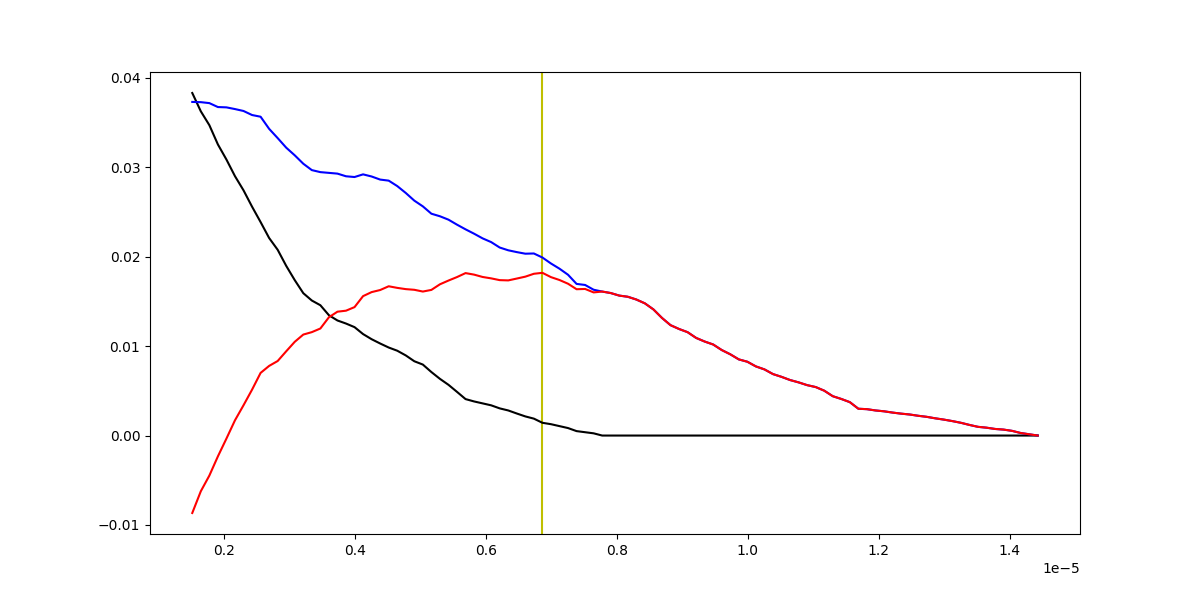

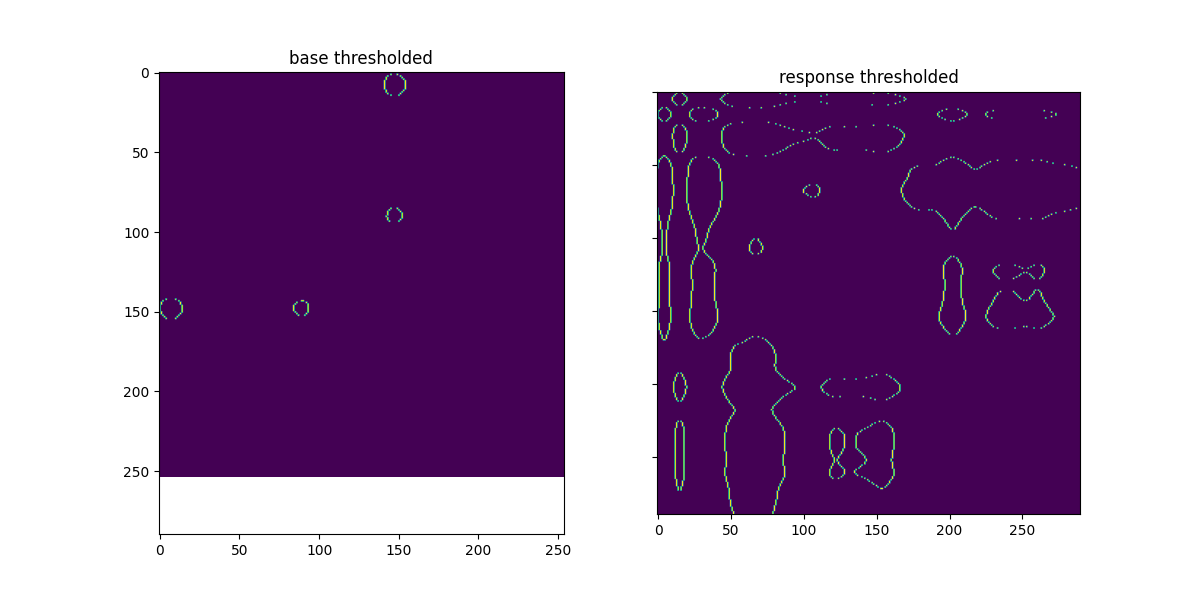

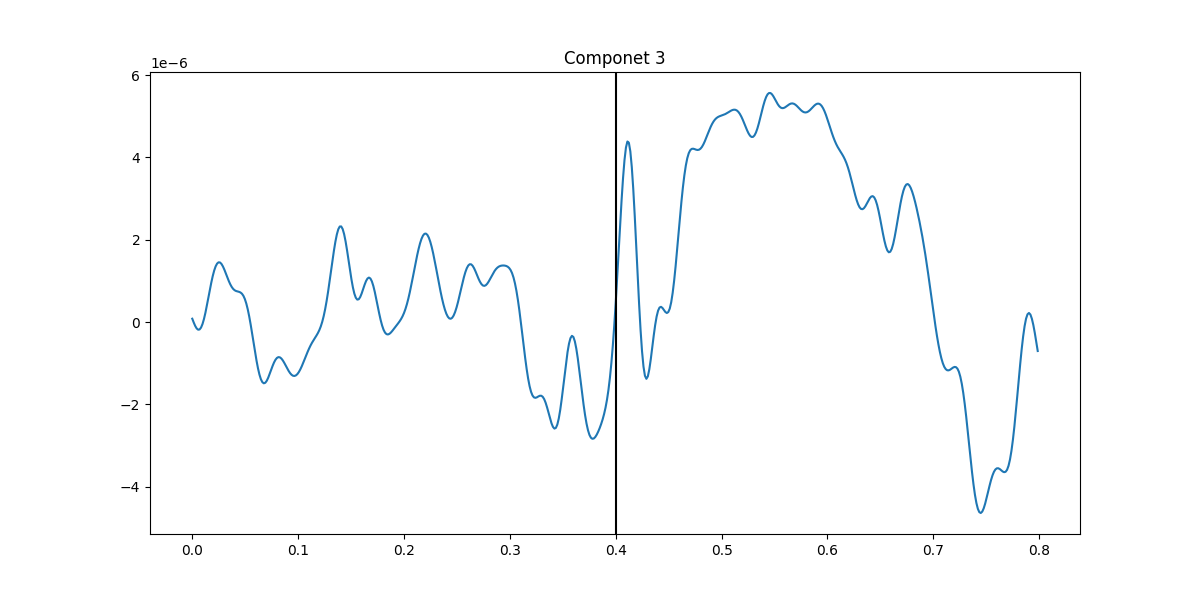

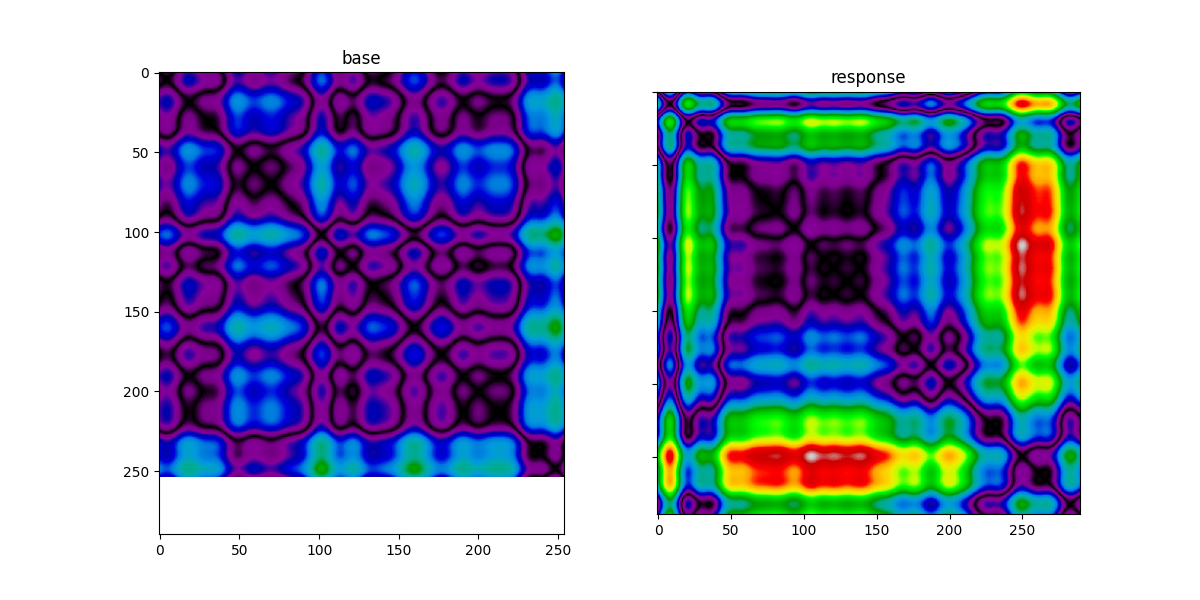

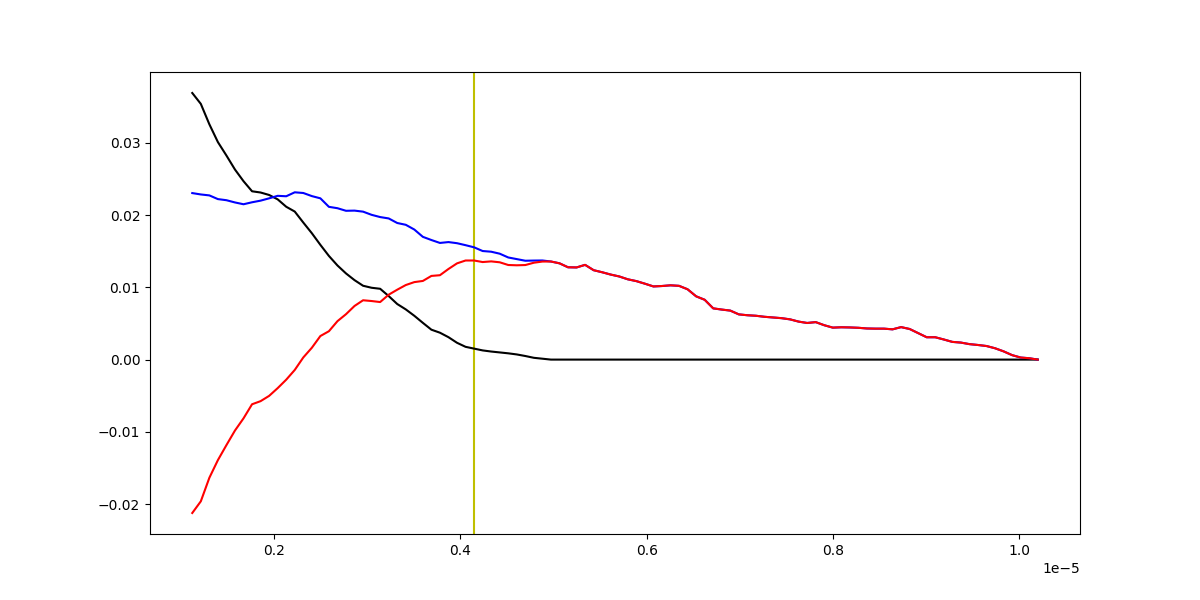

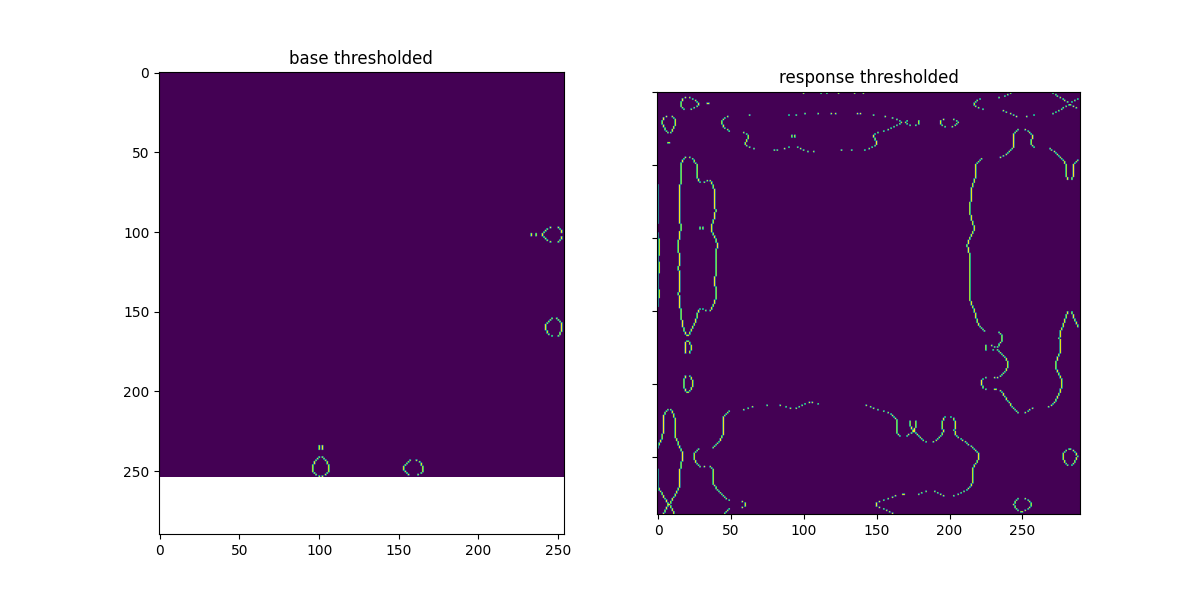

In [8]:
for d in range(pci_st_result["n_dims"]):

    plt.figure()
    plt.title(f"Componet {d}")
    plt.plot(pci_st_result["times"],pci_st_result["signal_svd"][d])
    plt.axvline(x=0.4,color="k")
    plt.show()

    fig, (ax0,ax1) = plt.subplots(1, 2, sharey=True)
    

    min_base = np.min(pci_st_result['D_base'][d])
    max_base = np.max(pci_st_result['D_base'][d])
    min_resp = np.min(pci_st_result['D_resp'][d])
    max_resp = np.max(pci_st_result['D_resp'][d])
    minimum = min(min_base,min_resp)
    maximum = max(max_base,max_resp)

    ax0.imshow(pci_st_result['D_base'][d],vmin=minimum, vmax=maximum, norm="symlog", cmap='nipy_spectral')
    ax1.imshow(pci_st_result['D_resp'][d],vmin=minimum, vmax=maximum, norm="symlog", cmap='nipy_spectral')

    ax0.set_title('base')
    ax1.set_title('response')

    plt.show()

    plt.figure()
    plt.axvline(x = pci_st_result["max_thresholds"][d], color="y", label = 'e^*')
    plt.plot(pci_st_result['thresholds'][:,d], pci_st_result['NST_base'][:,d], 'black', label='NST_base')
    plt.plot(pci_st_result['thresholds'][:,d], pci_st_result['NST_resp'][:,d], 'b', label='NST_resp')
    plt.plot(pci_st_result['thresholds'][:,d], pci_st_result['NST_diff'][:,d], 'r', label='NST_diff')

    plt.show()

    fig, (ax0,ax1) = plt.subplots(1, 2, sharey=True)

    im0 = ax0.imshow(pci_st_result['T_base'][d])
    im1 = ax1.imshow(pci_st_result['T_resp'][d])

    ax0.set_title('base thresholded')
    ax1.set_title('response thresholded')

    plt.show()

In [9]:
pci_st_result["PCI"]

18.966371346535798